In [1]:
import sys
import random
import hashlib
import numpy as np
from os.path import abspath, join
sys.path.append(abspath(join('../..')))
sys.path.append(abspath(join('..')))

from math import pi

from LevelSetPy.Utilities import *
from LevelSetPy.BoundaryCondition import *
from LevelSetPy.Visualization import *
# from LevelSetPy.DynamicalSystems import *
from LevelSetPy.Grids import *
from LevelSetPy.DynamicalSystems import *
from LevelSetPy.InitialConditions import *
from LevelSetPy.SpatialDerivative import *
from LevelSetPy.ExplicitIntegration.Dissipation import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
'we will first create the grids coverage for the respective birds'
# for every agent, create the grid bounds
grid_mins = [[-1, -1, -np.pi]]
grid_maxs = [[1, 1, np.pi]]   
grids = flockGrid(grid_mins, grid_maxs, dx=.1, N=101)
ref_bird = BirdSingle(grids[0], 1, 1, None, \
                    random.random(), label=0) 
print(ref_bird.position())

[0.99558554 1.15271013 8.        ]


In [ ]:
'we will first create the grids coverage for the respective birds'
# for every agent, create the grid bounds
grid_min = [-1, -1, -np.pi]
grid_max = [1, 1, np.pi] 
grid = createGrid(grid_min, grid_max, N=101, 2)
ref_bird = BirdSingle(grid, 1, 1, np.array((0, 0, 0)), \
                    random.random(), label=0) 
print(ref_bird.position())

In [3]:
print(ref_bird)  

num_agents=10
neighs = [BirdSingle(grids[i], 1, 1, None, \
                    random.random(), label=i) for i in range(1, num_agents)]
ref_bird.update_neighbor(neighs)
print(ref_bird)

Agent: 0 | Neighbors: 0 || valence: 0.
Agent: 0 | Neighbors: [1, 2, 3, 4, 5, 6, 7, 8, 9] || valence: 9.


In [14]:
ref_bird = BirdSingle(grids[0], 1, 1, None, \
                    random.random(), label=21)          
print(ref_bird)    
neighs = [BirdSingle(grids[i], 1, 1, None, \
                    random.random(), label=random.randint(10, 100)) for i in range(1, num_agents)]                
ref_bird.update_neighbor(neighs)                    
print(ref_bird)                    

Agent: 21 | Neighbors: 0 || valence: 0.
Agent: 21 | Neighbors: [12, 27, 28, 31, 49, 60, 75, 81, 82] || valence: 9.


In [19]:
# del flock
flock = BirdFlock(grids, num_agents, grid_nodes=101)
targ = flock.flock_payoff
spacing=tuple(flock.grid[0].dx.flatten().tolist())

# this zero level set is invisible. Target set is probs incorrect
targmesh = implicit_mesh(targ, level=None, \
                         spacing=spacing, \
                         edge_color='b', face_color='b')

This one for target set involving one evader and multiple pursuers. Any pursuer can capture the evader.

In [20]:
evader = flock.vehicles[0]
target_set = np.zeros((flock.N-1,)+(evader.grid.shape), dtype=np.float64)

#pursuer and evader targets
evader_set = shapeCylinder(evader.grid, 2, radius=evader.neigh_rad) 
pursuer_sets = [shapeCylinder(pursuer.grid, 2, radius=pursuer.neigh_rad) for pursuer in flock.vehicles[1:]]

# define capture targets
capture = evader_set
for i in range(len(pursuer_sets)):
    capture = shapeUnion(pursuer_sets[i], capture)

# define avoid sets: every pursuer must avoid one another
avoid_set = np.zeros((evader.grid.shape), dtype=np.float64)
for i in range(len(pursuer_sets)):
    avoid_set = shapeUnion(pursuer_sets[i], capture)
# # Target Set 1: Every pursuer must capture the evader
# idx=0
# for pursuer in flock.vehicles[1:]:
#     for i in range(pursuer.grid.dim):
#         'Evader captured by this pursuer: sqrt([x_1^2 - x_1^2]+[x_2^2-x_2^2])'
#         if i != pursuer.axis_align:
#             """
#                 Note the use of abs to avoid numpy runtime warnings.
#                 Makes all the more sense since the sdf is +ve within the interface
#             """
#             target_set[idx] += np.abs(pursuer.grid.xs[i]**2 - evader.grid.xs[i]**2)
#     target_set[idx] = np.sqrt(target_set[idx])
#     idx += 1

# # define avoid sets: every pursuer must avoid one another

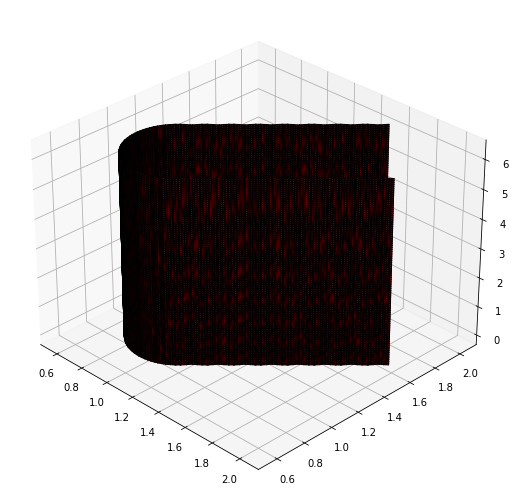

In [21]:
spacing=tuple(evader.grid.dx.flatten().tolist())

targmesh = implicit_mesh(capture, level=0, \
                         spacing=spacing, \
                         edge_color='k', face_color='r')
    
# visualize the BRAT set for this number of agents
fig = plt.figure(figsize=(16,9))
gs  = gridspec.GridSpec(1, 1, fig)
ax = plt.subplot(gs[0], projection='3d')
ax.add_collection3d(targmesh)
ax.set_xlim(.5, 2.1)
ax.set_ylim(.5, 2.1)
ax.set_zlim(-.2, 6.5)
ax.view_init(azim=-45, elev=30)
plt.show()

This one for target set involving leaderless coordination. Every agent within the flock must maintain a metric distance from one the other. There is a repulsive force between each agent and a predator.

In [24]:
flock = BirdFlock(grids, num_agents, grid_nodes=101)
target_set = np.zeros((flock.N,)+(grids[0].shape), dtype=np.float64)

# print(target_set.shape)
#pursuer and evader targets
agents_targets = [shapeCylinder(agent.grid, 2, radius=agent.neigh_rad) for agent in flock.vehicles]

# define avoid targets: neighbors of agent i must be within a fixed metric r_c of i
# for idx in range(len(agents_targets)):
#     this_agent = agents_targets.vehicles[idx]
#     this_agent = np.maximum(this_agent, agents_targets[idx])


# Any pursuer captures the evader
'min(sqrt(\{ [x_1^2 - x_1^2]+[x_2^2-x_2^2]) \})'
capture = target_set[0]
for i in range(1, len(target_set)):
    capture = np.minimum(target_set[i], capture)
    #capture = np.maximum(capture, target_set[i]) 
#capture -= evader.neigh_rad
# capture = evader_set
# for i in range(len(pursuer_sets)):
#     capture = shapeUnion(pursuer_sets[i], capture)

# define avoid sets: every pursuer must avoid one another

# # Target Set 1: Every pursuer must capture the evader
# idx=0
# for pursuer in flock.vehicles[1:]:
#     for i in range(pursuer.grid.dim):
#         'Evader captured by this pursuer: sqrt([x_1^2 - x_1^2]+[x_2^2-x_2^2])'
#         if i != pursuer.axis_align:
#             """
#                 Note the use of abs to avoid numpy runtime warnings.
#                 Makes all the more sense since the sdf is +ve within the interface
#             """
#             target_set[idx] += np.abs(pursuer.grid.xs[i]**2 - evader.grid.xs[i]**2)
#     target_set[idx] = np.sqrt(target_set[idx])
#     idx += 1

# # define avoid sets: every pursuer must avoid one another

(10, 101, 101, 101)


In [23]:
spacing=tuple(evader.grid.dx.flatten().tolist())

targmesh = implicit_mesh(capture, level=0, \
                         spacing=spacing, \
                         edge_color=None, face_color='r')
    
# visualize the BRAT set for this number of agents
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16,9))
gs  = gridspec.GridSpec(1, 1, fig)
ax = plt.subplot(gs[0], projection='3d')
ax.add_collection3d(targmesh)
ax.set_xlim(-.25, 1.4)
ax.set_ylim(0, 1.4)
ax.set_zlim(-2.2, 9.5)
ax.view_init(azim=-45, elev=30)
plt.show()

ValueError: Surface level must be within volume data range.

In [ ]:
# it feels like we also need create the case for when birds in a flock have a sparse interaction.

In [ ]:
# compute nearest neigbors on a grid

In [ ]:
# Now create classes for flocks splitting, flocks contraction, and flocks expansion.

In [ ]:
dubins_flock

In [ ]:

brt = np.load("../data/rcbrt.npz")['brt']
brt_time = np.load("../data/rcbrt.npz")['brt_time']
brt_time += [brt_time[-1]]
                                  
f = plt.figure(figsize=(16,9))
gs  = gridspec.GridSpec(2,2, f)


def plot_brt(ax, mesh, time_step):
	ax.grid('on')
	ax.add_collection3d(mesh)  
	xlim = (0, 1.75)
	ylim = (0, 1.75)
	zlim = (0, 2*np.pi)

	ax.set_xlim3d(*xlim)
	ax.set_ylim3d(*ylim)
	ax.set_zlim3d(*zlim)
	ax.set_title(rf'BRT at {time_step}/2.5 secs.', \
			fontdict={'fontsize':18, 'fontweight':'bold'})


# slices to plot:
slc = [0, 3, 7, 10]
brt_time = np.linspace(0, 2.0, 11)
ax = [plt.subplot(gs[0, 0], projection='3d'), 
	  plt.subplot(gs[0, 1], projection='3d'),
	  plt.subplot(gs[1, 0], projection='3d'),
	  plt.subplot(gs[1, 1], projection='3d')]
i=0
for slc_num in slc:		
	mesh = implicit_mesh(brt[slc_num], level=0, spacing=tuple(g.dx.flatten().tolist()),
									edge_color=None,  face_color='orchid')
	plot_brt(ax[i], mesh, brt_time[slc_num])
	i+=1	
plt.show()


In [ ]:
def controllability(g, gr, attr, value_func_init):
	fontdict = {'fontsize':28, 'fontweight':'bold'}
	f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

	ax1.contour(g.xs[0], g.xs[1], attr, colors='red')
	ax1.set_title('Analytical TTR', fontdict =fontdict)
	ax1.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax1.set_ylabel(r"$x_2 (ms^{-1})$", fontdict =fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_xlim([-1.02, 1.02])
	ax1.set_ylim([-1.01, 1.01])
	ax1.grid()

	ax2.contour(gr.xs[0], gr.xs[1], value_func_init, colors='blue')
	ax2.set_title('Numerical TTR', fontdict =fontdict)
	ax2.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax2.set_xlim([-1.02, 1.02])
	ax2.set_ylim([-1.01, 1.01])
	ax2.grid('on')
	ax2.tick_params(axis='both', which='major', labelsize=28)
	ax2.tick_params(axis='both', which='minor', labelsize=18)
	ax2.legend(loc="center left", fontsize=8) 

	f.suptitle(f"Levelsets")

	f.canvas.draw()
	f.canvas.flush_events()
	time.sleep(args.pause_time)

In [ ]:
g.xs = [g.xs[i].get() for i in range(g.dim)]
gr.xs = [gr.xs[i].get() for i in range(gr.dim)]
view_noncontrollability(g, gr, attr, value_rob)

In [ ]:
gs

In [ ]:
p1, p2, mode= obj.p1.pursuer, obj.p1.evader, 'capture'

assert isfield(p1, 'center'), 'player I must have a center '\
                                'defined for its capture equation.'
assert isfield(p2, 'center'), 'player II must have a center '\
                                'defined for its capture equation.'
assert isfield(p1, 'grid'), 'player I must have its grid info'
assert isfield(p2, 'grid'), 'player II must have its grid info'

x1 = p1.grid.xs
x2 = p2.grid.xs

p1_dyn  = cell(3)
p2_dyn = cell(3)

p1_dyn[0] = obj.vp*np.cos(x1[2])
p1_dyn[1] = obj.vp*np.sin(x1[2])
p1_dyn[2] = obj.we

p2_dyn[0] = obj.ve*np.cos(x2[2])
p2_dyn[1] = obj.ve*np.sin(x2[2])
p2_dyn[2] = obj.wp

data_agent1 = np.zeros(p1.grid.shape)
data_agent2 = np.zeros(p2.grid.shape)

if isfield(p1, 'center') and numel(p1.center==1):
    p1.center = p1.center*np.ones((p1.grid.dim,1), dtype=np.float64)
if isfield(p2, 'center') and numel(p2.center==1):
    p2.center = p2.center*np.ones((p2.grid.dim,1), dtype=np.float64)
        

### This for the Double Integrator

In [ ]:
import cupy as cp
import numpy as np

import sys
from os.path import abspath, join
sys.path.append(abspath(join('../..')))
from LevelSetPy.Utilities import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.Helper import postTimeStepTTR
from LevelSetPy.Visualization import implicit_mesh
from LevelSetPy.DynamicalSystems import DoubleIntegrator
from LevelSetPy.SpatialDerivative import upwindFirstWENO5
from LevelSetPy.ExplicitIntegration import artificialDissipationGLF
from LevelSetPy.ExplicitIntegration.Integration import odeCFL3, odeCFLset
from LevelSetPy.ExplicitIntegration.Term import termRestrictUpdate, termLaxFriedrichs


In [ ]:
gmin = np.array(([[-1, -1]]),dtype=np.float64).T
gmax = np.array(([[1, 1]]),dtype=np.float64).T
g = createGrid(gmin, gmax, 101, None)

eps_targ = 1.0
u_bound = 1
target_rad = .2 #eps_targ * np.max(g.dx)
dint = DoubleIntegrator(g, u_bound)
value_time2reach = dint.min_time2reach() - target_rad
value_time2reach = np.maximum(0, value_time2reach)

In [ ]:
above_curve=dint.grid.xs[0]>dint.Gamma
below_curve=dint.grid.xs[0]<dint.Gamma
on_curve=dint.grid.xs[0]==dint.Gamma

reach_term1  = (dint.grid.xs[1] + np.emath.sqrt(4*dint.grid.xs[0] + \
                         2 * dint.grid.xs[1]**2))*above_curve
reach_term2 =  (-dint.grid.xs[1]+np.emath.sqrt(-4*dint.grid.xs[0] + \
                2 * dint.grid.xs[1]**2) )*below_curve
reach_term3 = np.abs(dint.grid.xs[1]) * on_curve
reach_time = reach_term1.real + reach_term2.real + reach_term3

In [ ]:
dataIn = cp.arange(1, 13).reshape(3, 4)
print('dataIn\n', dataIn)
indices =[ [3], [5]]
print()
print(dataIn[cp.ix_(*indices)])

### Multiple vehicles

In [ ]:

obj = Bundle({})


pdDims = 2; N = 100
v, w = +1, +1
obj.ve, obj.vp = v, v
obj.we, obj.wp = -w, w


# get player (pursuer) 1's state space
gmin = np.array(([[-5, -5, -pi]])).T
gmax = np.array(([[0, 0, pi]])).T
obj.p1 = Bundle({'pursuer':Bundle({}), 'evader':Bundle({})})
obj.p1.pursuer.grid = createGrid(gmin, gmax, N, pdDims)
obj.p1.pursuer.center = np.array(([[-2.5, -2.5, 0]]),dtype=np.float64).T
obj.p1.pursuer.radius = 0.5
obj.p1.pursuer.basis = np.array(([[1,0,0]]))

# get player (evader) 2's state space
gmin = np.array(([[0, 0, pi]])).T
gmax = np.array(([[5, 5, 3*pi]])).T
obj.p1.evader.grid = createGrid(gmin, gmax, N, pdDims)
obj.p1.evader.center = np.array(([[2.5, 2.5, 2*pi]]),dtype=np.float64).T
obj.p1.evader.radius = .5
obj.p1.evader.basis = np.array(([[0,1,0]]))

# get player (pursuer) 3's state space
gmin = np.array(([[5, 5, 3*pi]])).T
gmax = np.array(([[10, 10, 5*pi]])).T
obj.p2 = Bundle({'pursuer':Bundle({}), 'evader':Bundle({})})
obj.p2.pursuer.grid = createGrid(gmin, gmax, N, pdDims)
obj.p2.pursuer.center = np.array(([[7.5, 7.5, 4*pi]]),dtype=np.float64).T
obj.p2.pursuer.radius = .5
obj.p2.pursuer.basis = np.array(([[0,0,1]]))

# get player (evader) 4's state space
gmin = np.array(([[10, 10, 5*pi]])).T
gmax = np.array(([[15, 15, 7*pi]])).T
obj.p2.evader.grid = createGrid(gmin, gmax, N, pdDims)
obj.p2.evader.center = np.array(([[12.5, 12.5, 6*pi]]),dtype=np.float64).T
obj.p2.evader.radius = .5
obj.p2.evader.basis = np.array(([[0,0,0,1]]))

# Full grid
gmin = np.array(([[-5, -5, -pi]])).T
gmax = np.array(([[15, 15, 7*pi]])).T
obj.full_grid = createGrid(gmin, gmax, N, pdDims)


In [ ]:
obj.p1.pursuer.xdot = dubins_absolute(obj, obj.p1.pursuer)
obj.p1.evader.xdot  = dubins_absolute(obj, obj.p1.evader)
obj.p2.pursuer.xdot = dubins_absolute(obj, obj.p2.pursuer)
obj.p2.evader.xdot  = dubins_absolute(obj, obj.p2.evader)
 
value_func = shapeRectangleByCorners(obj.full_grid, lower=-3, upper=13)

In [ ]:
# we now have a large value function, decompose the value w.r.t to the
# basis of the four vehicles to get its correspondiung decomposition into diff bases

In [ ]:
# compose rhe full grid as a tensor of all players
obj.grid_compose_vs = obj.p1.pursuer.grid.vs + obj.p1.evader.grid.vs + \
                      obj.p2.pursuer.grid.vs + obj.p2.evader.grid.vs
print([x.shape for x in obj.grid_compose_vs])

# too big
#FullTensor = np.meshgrid(*obj.grid_compose_vs, indexing='ij')

In [ ]:
# direction cosine of p1.pursuer w.r.t p1.evader
obj.p1.pursuer.basis_p1evader = np.dot(obj.p1.pursuer.basis.T, obj.p1.evader.basis)

In [ ]:
p1_pursuer = np.asarray(obj.p1.pursuer.grid.xs).transpose([1,2,3,0])
p1_evader = np.asarray(obj.p1.evader.grid.xs).transpose([1,2,3,0])
p2_pursuer = np.asarray(obj.p2.pursuer.grid.xs).transpose([1,2,3,0])
p2_evader = np.asarray(obj.p2.evader.grid.xs).transpose([1,2,3,0])
FT = np.concatenate((p1_pursuer, p1_evader), )
FT.shape

# use HOSVD to compute optimal rotation vector of one agent's state space to another's state space

def kabsch(P, Q):
    """
    Using the Kabsch algorithm with two sets of paired point P and Q, centered
    around the centroid. Each vector set is represented as an NxD
    matrix, where D is the the dimension of the space.
    The algorithm works in three steps:
    - a centroid translation of P and Q (assumed done before this function
      call)
    - the computation of a covariance matrix C
    - computation of the optimal rotation matrix U
    For more info see http://en.wikipedia.org/wiki/Kabsch_algorithm
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    U : matrix
        Rotation matrix (D,D)
    """

    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return U


In [ ]:
a = np.arange(9).reshape(3,3)
b, c = 2*a, 3*a

In [ ]:
np.minimum(a, b, c)

In [ ]:
a = a.flatten()
a[1:-1]